In [1]:
import re
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from collections import defaultdict
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fahad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# file_path = 'C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/Data/reddit.csv'
file_path = 'C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/Data/reddit_processed.csv'
df = pd.read_csv(file_path, dtype={'thread_id': str, 'comment_id': str})
df

,subreddit,msg_type,score,link,author,datetime,thread_id,comment_id,title,thread_text,title_processed,thread_text_processed,combined_processed,year,month
0,AskEurope,thread_start,0,https://www.reddit.com/r/AskEurope/comments/44...,u/Just-An-Asshole,2016-02-08 23:02:00,44szks,0,Question about the UK Court System,Hello! I just finished reading [this article]...,question about the uk court system,question about the uk court system hello i jus...,question about the uk court system hello i jus...,2016,2
1,AskEurope,comment,8,https://www.reddit.com/r/AskEurope/comments/44...,u/lgf92,2016-02-08 23:59:00,44szks,czspr8i,Question about the UK Court System,There's almost certainly more to it than is be...,question about the uk court system,there is almost certainly more to it than is b...,question about the uk court system there is al...,2016,2
2,AskEurope,comment,3,https://www.reddit.com/r/AskEurope/comments/44...,u/mrNONDESCRIPT,2016-02-09 00:12:00,44szks,czsqabq,Question about the UK Court System,"We have two types of court, Magistrate Courts ...",question about the uk court system,we have two types of court magistrate courts a...,question about the uk court system we have two...,2016,2
3,AskEurope,comment,1,https://www.reddit.com/r/AskEurope/comments/44...,u/nearlydeadasababy,2016-02-09 17:33:00,44szks,czthzzh,Question about the UK Court System,&gt; that at least merits some investigation\...,question about the uk court system,that at least merits some investigation as al...,question about the uk court system that at le...,2016,2
4,AskEurope,comment,1,https://www.reddit.com/r/AskEurope/comments/44...,u/hoffi_coffi,2016-02-11 17:01:00,44szks,czw1jl9,Question about the UK Court System,"It was a bit of an anomaly, hence it made the ...",question about the uk court system,it was a bit of an anomaly hence it made the n...,question about the uk court system it was a bi...,2016,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
546081,technology,comment,1,https://www.reddit.com/r/technology/comments/z...,u/[deleted],2012-09-16 11:12:00,zy88g,c68v8w5,"Google Fiber TV now includes Cartoon Network, ...",I would fear Google less because they have the...,google fiber tv now includes cartoon network c...,i would fear google less because they have the...,google fiber tv now includes cartoon network c...,2012,9
546082,technology,thread_start,2624,https://www.reddit.com/r/technology/comments/z...,u/nyphrex,2012-09-17 04:02:00,zzyir,0,The light bulb... reinvented,NaN,the light bulb reinvented,the light bulb reinvented nan,the light bulb reinvented,2012,9
546083,technology,comment,2,https://www.reddit.com/r/technology/comments/z...,u/AmericCanuck,2012-09-17 08:37:00,zzyir,c69aghb,The light bulb... reinvented,"Old technology. Google Insteon, universal-dev...",the light bulb reinvented,old technology google insteon complete home s...,the light bulb reinvented old technology googl...,2012,9
546084,technology,comment,1,https://www.reddit.com/r/technology/comments/z...,u/[deleted],2012-09-17 10:09:00,zzyir,c69bbhb,The light bulb... reinvented,"Honestly, if the bulb lasts even 10 years I wo...",the light bulb reinvented,honestly if the bulb lasts even years i would...,the light bulb reinvented honestly if the bulb...,2012,9


In [13]:
# List of subreddits to keep
subreddits_to_keep = ['AskEurope', 'AskReddit', 'privacy', 'security', 'technology']

# Filter the DataFrame
df = df[df['subreddit'].isin(subreddits_to_keep)]

# Convert 'datetime' column to datetime dtype if it's not already
df['datetime'] = pd.to_datetime(df['datetime'])

# Filter rows where the year is between 2010 and 2020
df = df[df['datetime'].dt.year.between(2010, 2020)]

df

,subreddit,msg_type,score,link,author,datetime,thread_id,comment_id,title,thread_text,title_processed,thread_text_processed,combined_processed
0,AskEurope,thread_start,0,https://www.reddit.com/r/AskEurope/comments/44...,u/Just-An-Asshole,2016-02-08 23:02:00,44szks,0,Question about the UK Court System,Hello! I just finished reading [this article]...,question about the uk court system,question about the uk court system hello i jus...,question about the uk court system hello i jus...
1,AskEurope,comment,8,https://www.reddit.com/r/AskEurope/comments/44...,u/lgf92,2016-02-08 23:59:00,44szks,czspr8i,Question about the UK Court System,There's almost certainly more to it than is be...,question about the uk court system,there is almost certainly more to it than is b...,question about the uk court system there is al...
2,AskEurope,comment,3,https://www.reddit.com/r/AskEurope/comments/44...,u/mrNONDESCRIPT,2016-02-09 00:12:00,44szks,czsqabq,Question about the UK Court System,"We have two types of court, Magistrate Courts ...",question about the uk court system,we have two types of court magistrate courts a...,question about the uk court system we have two...
3,AskEurope,comment,1,https://www.reddit.com/r/AskEurope/comments/44...,u/nearlydeadasababy,2016-02-09 17:33:00,44szks,czthzzh,Question about the UK Court System,&gt; that at least merits some investigation\...,question about the uk court system,that at least merits some investigation as al...,question about the uk court system that at le...
4,AskEurope,comment,1,https://www.reddit.com/r/AskEurope/comments/44...,u/hoffi_coffi,2016-02-11 17:01:00,44szks,czw1jl9,Question about the UK Court System,"It was a bit of an anomaly, hence it made the ...",question about the uk court system,it was a bit of an anomaly hence it made the n...,question about the uk court system it was a bi...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
583762,technology,comment,1,https://www.reddit.com/r/technology/comments/z...,u/[deleted],2012-09-16 11:12:00,zy88g,c68v8w5,"Google Fiber TV now includes Cartoon Network, ...",I would fear Google less because they have the...,google fiber tv now includes cartoon network c...,i would fear google less because they have the...,google fiber tv now includes cartoon network c...
583767,technology,thread_start,2624,https://www.reddit.com/r/technology/comments/z...,u/nyphrex,2012-09-17 04:02:00,zzyir,0,The light bulb... reinvented,NaN,the light bulb reinvented,the light bulb reinvented nan,the light bulb reinvented
583768,technology,comment,2,https://www.reddit.com/r/technology/comments/z...,u/AmericCanuck,2012-09-17 08:37:00,zzyir,c69aghb,The light bulb... reinvented,"Old technology. Google Insteon, universal-dev...",the light bulb reinvented,old technology google insteon complete home s...,the light bulb reinvented old technology googl...
583769,technology,comment,1,https://www.reddit.com/r/technology/comments/z...,u/[deleted],2012-09-17 10:09:00,zzyir,c69bbhb,The light bulb... reinvented,"Honestly, if the bulb lasts even 10 years I wo...",the light bulb reinvented,honestly if the bulb lasts even years i would...,the light bulb reinvented honestly if the bulb...


975997 rows × 10 columns

In [ ]:
# Dictionary for contractions
contraction_dict = {
    "it's": "it is", "aren't": "are not", "can't": "cannot", "couldn't": "could not",
    "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not",
    "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'll": "he will",
    "he's": "he is", "I'd": "I would", "I'll": "I will", "I'm": "I am", "I've": "I have",
    "isn't": "is not", "it's": "it is", "let's": "let us", "might've": "might have",
    "must've": "must have", "mustn't": "must not", "shan't": "shall not", "she'd": "she would",
    "she'll": "she will", "she's": "she is", "should've": "should have", "shouldn't": "should not",
    "that's": "that is", "there's": "there is", "they'd": "they would", "they'll": "they will",
    "they're": "they are", "they've": "they have", "we'd": "we would", "we're": "we are",
    "we've": "we have", "weren't": "were not", "what'll": "what will", "what're": "what are",
    "what's": "what is", "what've": "what have", "where's": "where is", "who'd": "who would",
    "who'll": "who will", "who's": "who is", "who've": "who have", "won't": "will not",
    "wouldn't": "would not", "you'd": "you would", "you'll": "you will", "you're": "you are",
    "you've": "you have",
    "it’s": "it is", "aren’t": "are not", "can’t": "cannot", "couldn’t": "could not",
    "didn’t": "did not", "doesn’t": "does not", "don’t": "do not", "hadn’t": "had not",
    "hasn’t": "has not", "haven’t": "have not", "he’d": "he would", "he’ll": "he will",
    "he’s": "he is", "I’d": "I would", "I’ll": "I will", "I’m": "I am", "I’ve": "I have",
    "isn’t": "is not", "it’s": "it is", "let’s": "let us", "might’ve": "might have",
    "must’ve": "must have", "mustn’t": "must not", "shan’t": "shall not", "she’d": "she would",
    "she’ll": "she will", "she’s": "she is", "should’ve": "should have", "shouldn’t": "should not",
    "that’s": "that is", "there’s": "there is", "they’d": "they would", "they’ll": "they will",
    "they’re": "they are", "they’ve": "they have", "we’d": "we would", "we’re": "we are",
    "we’ve": "we have", "weren’t": "were not", "what’ll": "what will", "what’re": "what are",
    "what’s": "what is", "what’ve": "what have", "where’s": "where is", "who’d": "who would",
    "who’ll": "who will", "who’s": "who is", "who’ve": "who have", "won’t": "will not",
    "wouldn’t": "would not", "you’d": "you would", "you’ll": "you will", "you’re": "you are",
    "you’ve": "you have"
}

def preprocess_text(text):
    if pd.isna(text):
        return text
    
    if not isinstance(text, str):
        text = str(text)
        
    # HTML character conversions
    html_char_map = {
        "&amp;": "&",
        "&apos;": "'",
        "&#39;": "'",
        "â€™": "'",
    }
    for html_char, replacement in html_char_map.items():
        text = text.replace(html_char, replacement)
        
    # Regex to match:
    # 1. Any possible email address format
    # 2. URLs starting with http/https and ending with .com or .fi (with optional spaces)
    # 3. Any string that includes a slash (assumed to be a path or URL)
    # 4. Domain-like strings that end with .com or .fi, including spaces before the extensions
    patterns = [
        r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\b',  # Email addresses, more inclusive to capture 'username@hostname'
        r'https?://[^ ]*\.(com|fi)\b',             # Full URLs
        r'\b[^ ]+/[^ ]+\b',                        # Paths with slashes
        r'\b[^ ]*\.\s*(com|fi)\b'                  # Domains with optional spaces
    ]
    combined_pattern = r'|'.join(patterns)         # Combine all patterns
    text = re.sub(combined_pattern, '', text)      # Remove matches of the combined pattern
    text = text.replace('[deleted]', '').replace('[removed]', '') # Replace [deleted] and [removed] with empty string
    text = text.lower()                            # Convert to lowercase
    words = text.split()                           # Split text into words
    text = " ".join([contraction_dict.get(word, word) for word in words]) # Replace contractions
    # text = re.sub(r'\b\w*(-\w*)+\b', '', text)     # Remove sequences of hyphenated words
    text = re.sub(r'â\w*', '', text)               # Remove codes starting with 'â'
    text = re.sub(r'&[^;\s]*', '', text)           # Remove HTML entities
    text = re.sub(r'\s+', ' ', text).strip()       # Remove extra whitespace
    text = re.sub(r'[^a-zA-Z\s]', '', text)        # Remove non-letter characters

    # text = re.sub(r'\b\w{1,2}\b', '', text) # Remove single and double character words
    # tokens = text.split()
    # tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    
    return text


tqdm.pandas(desc="Processing")

df['title_processed'] = df['title'].progress_apply(preprocess_text)
df['thread_text_processed'] = df['thread_text'].progress_apply(preprocess_text)
df['combined_processed'] = df[['title_processed', 'thread_text_processed']].progress_apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)
df.loc[df['msg_type'] == 'thread_start', 'thread_text_processed'] = df.loc[df['msg_type'] == 'thread_start'].progress_apply(
    lambda x: ' '.join([str(x['title_processed']), str(x['thread_text_processed'])]).strip(), axis=1)
df.dropna(subset=['thread_text_processed'], inplace=True)
# df = df.drop(['link', 'author'], axis=1)

df.to_csv('C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/Data/reddit_processed.csv', index=False)

In [29]:
df.to_csv('C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/Data/reddit_processed.csv', index=False)

In [6]:
# df = df.drop(['title_processed', 'thread_text_processed'], axis=1)
# df.to_csv('C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/Data/reddit_processed.csv', index=False)

In [28]:
# print(f"before dataframe shape: {df.shape}")
# # Count comments per thread_id
# comment_counts = df[df['msg_type'] == 'comment'].groupby('thread_id').size()

# # Identify thread_ids with at least 3 comments
# valid_thread_ids = comment_counts[comment_counts >= 3].index

# # Filter out posts with fewer than 3 comments
# df = df[df['thread_id'].isin(valid_thread_ids)].copy()

# print(f"After dataframe shape: {df.shape}")

# df = df.drop(['title_processed', 'thread_text_processed'], axis=1)
# df = df[['subreddit', 'msg_type', 'score', 'link', 'author', 'datetime', 'thread_id', 'comment_id', 'title', 'thread_text']]
# df.to_csv('C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/Data/reddit_clean.csv', index=False)

before dataframe shape: (1533450, 12)
After dataframe shape: (1390223, 12)


In [33]:
# df = df.dropna(subset=['title_processed', 'thread_text_processed'], how='all')
# df = df[~((df['msg_type'] == 'comment') & (df['thread_text_processed'].isna() | df['thread_text_processed'].str.strip() == ''))]
# Remove submissions with no comments
# df = df.groupby('thread_id').filter(lambda x: (x['msg_type'] == 'comment').any())

# df = df.dropna(subset=['thread_text_processed'])

# Alternatively, if you want to remove rows where `thread_text_processed` is an empty string as well

# df = df[~((df['msg_type'] == 'comment') & (df['thread_text_processed'].str.strip() == ''))]


In [5]:
df
# df

,subreddit,msg_type,score,link,author,datetime,thread_id,comment_id,title,thread_text,title_processed,thread_text_processed,combined_processed
35991,AskEurope,thread_start,0,https://www.reddit.com/r/AskEurope/comments/44...,u/Just-An-Asshole,2016-02-08 23:02:00,44szks,0,Question about the UK Court System,Hello! I just finished reading [this article]...,question about the uk court system,question about the uk court system hello i jus...,question about the uk court system hello i jus...
35992,AskEurope,comment,8,https://www.reddit.com/r/AskEurope/comments/44...,u/lgf92,2016-02-08 23:59:00,44szks,czspr8i,Question about the UK Court System,There's almost certainly more to it than is be...,question about the uk court system,there is almost certainly more to it than is b...,question about the uk court system there is al...
35993,AskEurope,comment,3,https://www.reddit.com/r/AskEurope/comments/44...,u/mrNONDESCRIPT,2016-02-09 00:12:00,44szks,czsqabq,Question about the UK Court System,"We have two types of court, Magistrate Courts ...",question about the uk court system,we have two types of court magistrate courts a...,question about the uk court system we have two...
35994,AskEurope,comment,1,https://www.reddit.com/r/AskEurope/comments/44...,u/nearlydeadasababy,2016-02-09 17:33:00,44szks,czthzzh,Question about the UK Court System,&gt; that at least merits some investigation\...,question about the uk court system,that at least merits some investigation as al...,question about the uk court system that at le...
35995,AskEurope,comment,1,https://www.reddit.com/r/AskEurope/comments/44...,u/hoffi_coffi,2016-02-11 17:01:00,44szks,czw1jl9,Question about the UK Court System,"It was a bit of an anomaly, hence it made the ...",question about the uk court system,it was a bit of an anomaly hence it made the n...,question about the uk court system it was a bi...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
907148,technology,thread_start,7930,https://www.reddit.com/r/technology/comments/z...,u/psychothumbs,2022-12-31 16:48:00,zzvntv,0,Sex Workers Have Been Banned From Airbnb for Y...,NaN,sex workers have been banned from airbnb for y...,sex workers have been banned from airbnb for y...,sex workers have been banned from airbnb for y...
907149,technology,thread_start,2624,https://www.reddit.com/r/technology/comments/z...,u/nyphrex,2012-09-17 04:02:00,zzyir,0,The light bulb... reinvented,NaN,the light bulb reinvented,the light bulb reinvented nan,the light bulb reinvented
907150,technology,comment,2,https://www.reddit.com/r/technology/comments/z...,u/AmericCanuck,2012-09-17 08:37:00,zzyir,c69aghb,The light bulb... reinvented,"Old technology. Google Insteon, universal-dev...",the light bulb reinvented,old technology google insteon complete home s...,the light bulb reinvented old technology googl...
907151,technology,comment,1,https://www.reddit.com/r/technology/comments/z...,u/[deleted],2012-09-17 10:09:00,zzyir,c69bbhb,The light bulb... reinvented,"Honestly, if the bulb lasts even 10 years I wo...",the light bulb reinvented,honestly if the bulb lasts even years i would...,the light bulb reinvented honestly if the bulb...


In [23]:
# Ensure datetime column is in datetime format
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

# Filter for the year 2023
# df_2023 = df[df['datetime'].dt.year == 2023]

# Filter for the years 2008-2022
# df_2008_2020 = df[(df['datetime'].dt.year >= 2008) & (df['datetime'].dt.year <= 2020)]

# Print the number of rows
print(f"Number of rows from 2010-2020: {len(df)}")
# print(f"Number of rows in 2023: {len(df)}")

Number of rows from 2010-2020: 546086


C:\Users\fahad\AppData\Local\Temp\ipykernel_13160\3337015438.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')


C:\Users\fahad\AppData\Local\Temp\ipykernel_13160\1204848748.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['datetime'] = pd.to_datetime(df['datetime'])


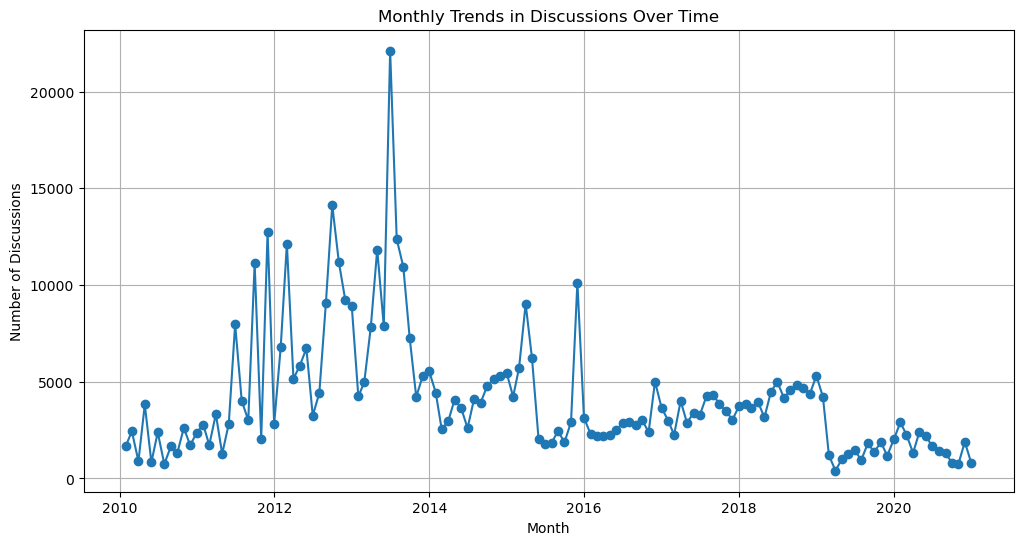

In [24]:
# Convert 'datetime' column to datetime type for easier manipulation
df['datetime'] = pd.to_datetime(df['datetime'])

# # Filter for the year 2023
# df_2023 = df[df['datetime'].dt.year == 2023]

# # Filter for the years 2008-2022
# df_2008_2020 = df[(df['datetime'].dt.year >= 2008) & (df['datetime'].dt.year <= 2020)]

# Group data by month and count occurrences
monthly_trends = df.set_index('datetime').resample('M').count()['thread_text_processed']

# Plotting the trend
plt.figure(figsize=(12, 6))
plt.plot(monthly_trends.index, monthly_trends.values, marker='o', linestyle='-')
plt.title('Monthly Trends in Discussions Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Discussions')
plt.grid(True)
plt.show()


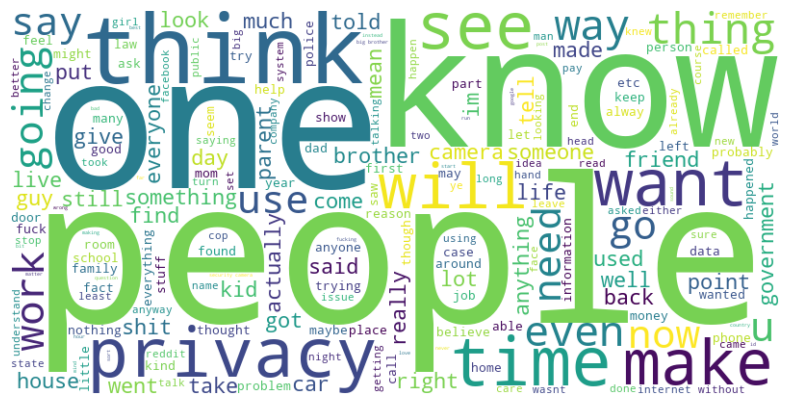

In [25]:
# Generate a word cloud for the most common words in discussions
text = ' '.join(df['thread_text_processed'].astype(str).tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


C:\Users\fahad\AppData\Local\Temp\ipykernel_13160\1660101551.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['datetime'].dt.year
C:\Users\fahad\AppData\Local\Temp\ipykernel_13160\1660101551.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df['datetime'].dt.month


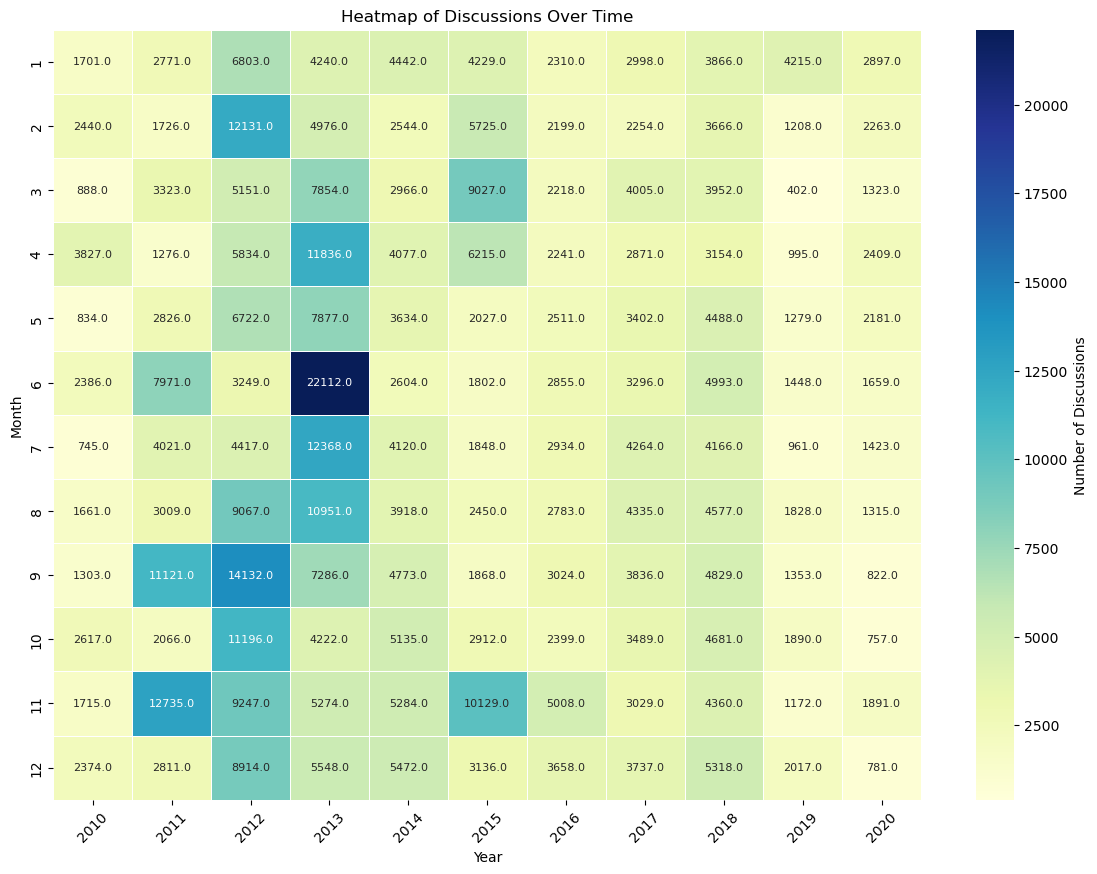

In [27]:
# Extract year and month
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month

# Group data by year and month and count occurrences
yearly_monthly_trends = df.groupby(['year', 'month']).count()['thread_text_processed']

# Ensure the index includes all years and months up to 2020
full_index = pd.MultiIndex.from_product([range(2010, 2021), range(1, 13)], names=['year', 'month'])
yearly_monthly_trends = yearly_monthly_trends.reindex(full_index, fill_value=0)

# Convert to a DataFrame and reset the index
yearly_monthly_trends_df = yearly_monthly_trends.reset_index()

# Pivot the DataFrame
heatmap_data = yearly_monthly_trends_df.pivot_table(index='month', columns='year', values='thread_text_processed', fill_value=0)

# Display the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt=".1f", annot_kws={"size": 8}, linewidths=.5, cbar_kws={'label': 'Number of Discussions'})
plt.title('Heatmap of Discussions Over Time')
plt.xlabel('Year')
plt.ylabel('Month')
plt.xticks(rotation=45)
plt.show()#2012 6803

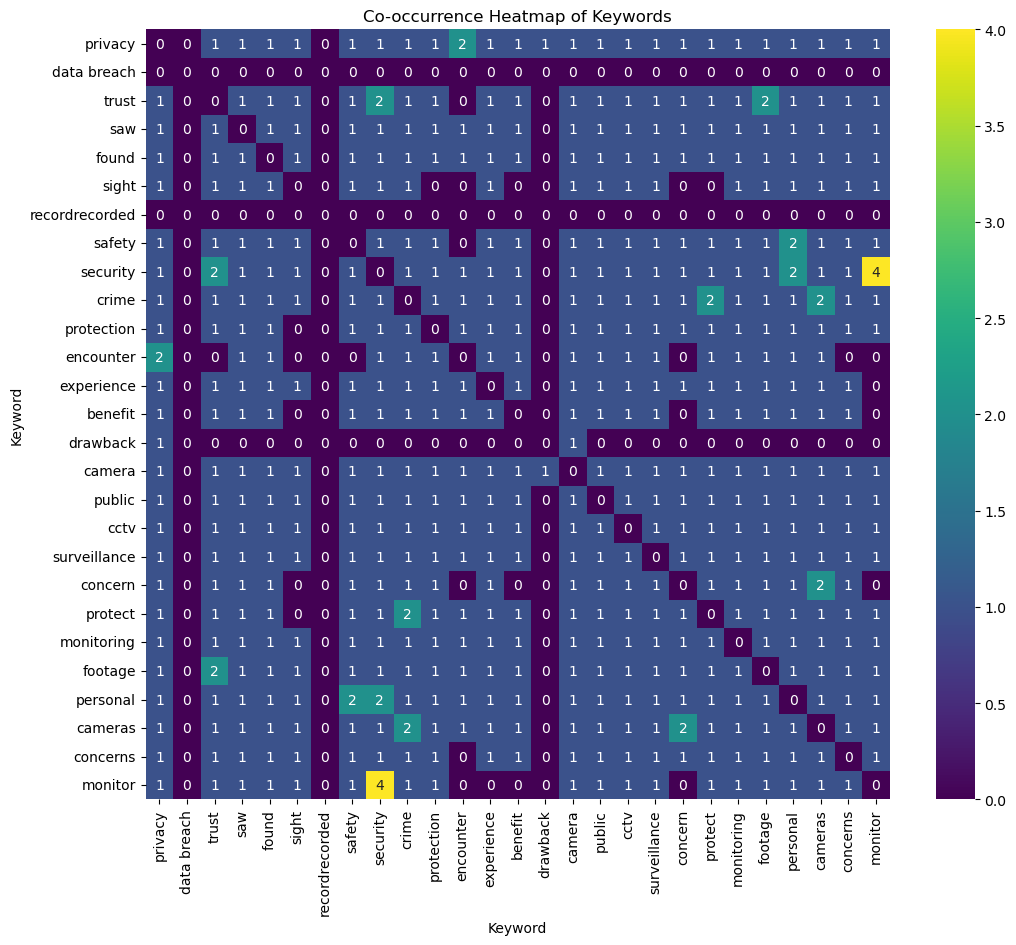

In [28]:
keywords = ['privacy', 'data breach', 'trust', 'saw', 'found', 'sight', 'record' 'recorded', 'safety', 'security', 'crime', 'protection', 'encounter', 'experience', 'benefit', 'drawback', 'camera', 'public', 'cctv', 'surveillance', 'concern', 'protect', 'monitoring', 'footage', 'personal', 'cameras', 'concerns', 'monitor']

# Function to find co-occurrences
def find_cooccurrences(text, keywords):
    cooccurrences = defaultdict(int)
    if pd.isna(text):
        return cooccurrences
    # print(text)
    tokens = text.split()
    
    for i, token in enumerate(tokens):
        if token in keywords:
            for j in range(max(0, i-5), min(len(tokens), i+6)):
                if tokens[j] != token and tokens[j] in keywords:
                    cooccurrences[(token, tokens[j])] += 1
    return cooccurrences

# Find co-occurrences in the dataset
cooccurrences = defaultdict(int)
for text in df['thread_text_processed']:
    cooccurrences.update(find_cooccurrences(text, keywords))

# Convert co-occurrences to a matrix
cooc_matrix = np.zeros((len(keywords), len(keywords)))
keyword_index = {keyword: idx for idx, keyword in enumerate(keywords)}

for (kw1, kw2), count in cooccurrences.items():
    i, j = keyword_index[kw1], keyword_index[kw2]
    cooc_matrix[i, j] = count
    cooc_matrix[j, i] = count

# Plot the co-occurrence heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cooc_matrix, xticklabels=keywords, yticklabels=keywords, cmap='viridis', annot=True, fmt='g')
plt.title('Co-occurrence Heatmap of Keywords')
plt.xlabel('Keyword')
plt.ylabel('Keyword')
plt.show()


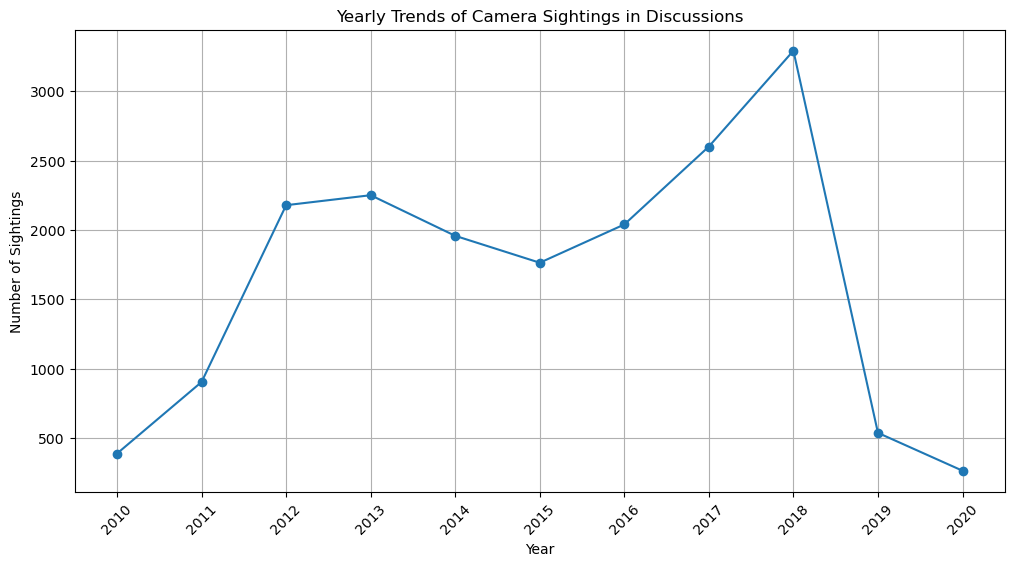

In [4]:
# Define keywords/phrases indicating a camera sighting
sighting_keywords = ['saw camera', 'camera saw', 'noticed camera', 'camera noticed', 'camera spotted', 'camera spot', 'camera sighted', 'camera sight', 'area camera', 'around camera', 'spotted camera', 'spot camera', 'sighted camera', 'sight camera', 'camera area', 'camera around', 'camera nearby', 'nearby camera', 'camera security', 'camera hidden', 'park camera', 'camera traffic', 'camera caught', 'camera recorded', 'camera filmed', 'footage camera', 'camera surveillance', 'surveillance camera', 'security camera', 'hidden camera', 'traffic camera', 'caught camera', 'recorded camera', 'filmed camera', 'camera footage', 'building camera', 'under camera surveillance', 'camera park', 'camera building', 'camera street', 'street camera', 'office camera', 'station camera', 'camera office', 'camera station']

# Convert 'datetime' column to datetime dtype if it's not already
df['datetime'] = pd.to_datetime(df['datetime'])

# Create a boolean column for camera sightings
df['camera_sighting'] = df['thread_text_processed'].apply(lambda x: any(phrase in x.lower() for phrase in sighting_keywords))
# print(sighting_data)

# Filter data to only include rows where a camera sighting is mentioned
sighting_data = df[df['camera_sighting']]

# Aggregate the sighting data by month
yearly_sightings = sighting_data.groupby(sighting_data['datetime'].dt.year).size().reset_index(name='num_sightings')

# Convert the datetime to string for plotting
yearly_sightings['datetime'] = yearly_sightings['datetime'].astype(str)

# Plot the yearly trends
plt.figure(figsize=(12, 6))
plt.plot(yearly_sightings['datetime'], yearly_sightings['num_sightings'], marker='o', linestyle='-')
plt.title('Yearly Trends of Camera Sightings in Discussions')
plt.xlabel('Year')
plt.ylabel('Number of Sightings')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [ ]:
# Define keywords related to privacy, security, and personal experiences
keywords = ['privacy', 'data breach', 'trust', 'saw', 'found', 'sight', 'record' 'recorded', 'safety', 'security', 'crime', 'protection', 'encounter', 'experience', 'benefit', 'drawback', 'camera', 'public', 'cctv', 'surveillance', 'concern', 'protect', 'monitoring', 'footage', 'personal', 'cameras', 'concerns', 'monitor']

# Count the frequency of each keyword in the processed text
keyword_counts = df['thread_text_processed'].str.split(expand=True).stack().value_counts()
keyword_counts = keyword_counts[keyword_counts.index.isin(keywords)]

# Plot the keyword frequencies
plt.figure(figsize=(12, 6))
sns.barplot(x=keyword_counts.values, y=keyword_counts.index, palette='viridis')
plt.title('Keyword Frequencies')
plt.xlabel('Frequency')
plt.ylabel('Keywords')
plt.show()


In [ ]:
# # Ensure datetime column is in datetime format
# df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

# # Filter for the year 2023
# df_2023 = df[df['datetime'].dt.year == 2023]

# # Count unique thread_id values for each subreddit
# unique_thread_counts = df_2023.groupby('subreddit')['thread_id'].nunique()

# # Filter to include only subreddits with unique thread_id counts greater than 20
# unique_thread_counts_filtered = unique_thread_counts[unique_thread_counts > 20]

# # Plot counts of unique thread_id values for each subreddit
# plt.figure(figsize=(12, 6))
# unique_thread_counts_filtered.plot(kind='bar')
# plt.title('Counts of Unique Thread IDs for Each Subreddit (Count > 20)')
# plt.xlabel('Subreddit')
# plt.ylabel('Counts of Unique Thread IDs')
# plt.xticks(rotation=90)
# plt.show()


In [ ]:
# # Ensure datetime column is in datetime format
# df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

# # Filter for the year 2023
# df_2023 = df[df['datetime'].dt.year == 2023]

# # Count unique thread IDs for each subreddit
# subreddit_thread_counts_2023 = df_2023[df_2023['msg_type'] == 'thread_start'].groupby('subreddit')['thread_id'].nunique()

# # Filter subreddits with less than 20 unique thread IDs
# subreddits_less_than_20_2023 = subreddit_thread_counts_2023[subreddit_thread_counts_2023 < 20]

# # Count the rows for subreddits with less than 20 threads
# rows_less_than_20_threads_2023 = df_2023[df_2023['subreddit'].isin(subreddits_less_than_20_2023.index)]

# # Display the counts
# print(f"Total rows in subreddits with less than 20 threads in 2023: {len(rows_less_than_20_threads_2023)}")

# # Display the specific counts for each subreddit with less than 20 threads
# print(rows_less_than_20_threads_2023['subreddit'].value_counts())

# # Plot the counts
# # subreddit_counts_2023 = rows_less_than_20_threads_2023['subreddit'].value_counts()

# # plt.figure(figsize=(12, 8))
# # subreddit_counts_2023.plot(kind='bar')
# # plt.title('Counts of Subreddits with Less than 20 Threads in 2023')
# # plt.xlabel('Subreddit')
# # plt.ylabel('Count of Rows')
# # plt.xticks(rotation=90)
# # plt.show()

In [ ]:
# # Ensure datetime column is in datetime format
# df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

# # Filter for the year 2023
# df_2023 = df[df['datetime'].dt.year == 2023]

# # Count the number of unique thread_ids per subreddit
# subreddit_thread_counts = df_2023.groupby('subreddit')['thread_id'].nunique()

# # Filter subreddits with less than 20 threads
# subreddits_less_than_20_threads = subreddit_thread_counts[subreddit_thread_counts < 20].index

# # Filter rows from these subreddits
# df_filtered = df_2023[df_2023['subreddit'].isin(subreddits_less_than_20_threads)]
# print(df_filtered)

# # Save to a CSV file
# output_file = 'C:/Users/fahad/OneDrive - Oulun yliopisto/Documents/reddit/Data/reddit_2023_lessthan20.csv'
# df_filtered.to_csv(output_file, index=False)
